In this Notebook, we are going to compare the automatic embedding based cluster with manual clustering

In [1]:
import pickle
def rdPickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def mkPikle(filename, content):
    with open(filename, 'wb') as f:
        pickle.dump(content, f)
        f.close()

In [2]:
df_summary_target = rdPickle('pickle/20News/df_summary_target.pkl')
df_summary_topic  = rdPickle('pickle/20News/df_summary_topic.pkl')
df_comb           = rdPickle('pickle/20News/df_comb.pkl')
df_comb_limited   = rdPickle('pickle/20News/df_comb_limited.pkl')
df_overall        = rdPickle('pickle/20News/df_overall.pkl')
embeddings        = rdPickle('pickle/20News/embeddings.pkl')
umap_embeddings   = rdPickle('pickle/20News/umap_embeddings.pkl')
cluster           = rdPickle('pickle/20News/cluster.pkl')

In [45]:
#mkPikle('pickle/20News/top1.pkl',top1)

Getting the newsgroup data clustered by human

In [24]:

from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [25]:
import pandas as pd
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [26]:
data1= pd.Series(newsgroups.data) 
data1=pd.DataFrame(data1) 
data1.columns = ['Data'] + data1.columns.tolist()[1:] 
data1['target'] = pd.Series(newsgroups.target)

In [84]:
data1[:2]

,Data,target,target_name
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",10,rec.sport.hockey
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3,comp.sys.ibm.pc.hardware


In [28]:
data1['target_name'] = [newsgroups.target_names[target] for target in data1['target']]

In [29]:
# for idx, cat in enumerate(newsgroups.target_names):
#     print(idx, cat)

In [86]:
df_comb['Topic']

0        -1
1        -1
2         4
3        59
4        -1
         ..
18841    90
18842    -1
18843    -1
18844    -1
18845    90
Name: Topic, Length: 18846, dtype: int64

In [30]:
data1.groupby(['target_name']).agg({"Data": ['count']}).keys()

MultiIndex([('Data', 'count')],
           )

In [31]:
df_overall = data1.groupby(['target_name']).agg({"Data": ['count']})

In [32]:
df_overall

,Data
,count
target_name,
alt.atheism,799
comp.graphics,973
comp.os.ms-windows.misc,985
comp.sys.ibm.pc.hardware,982
comp.sys.mac.hardware,963
comp.windows.x,988
misc.forsale,975
rec.autos,990


In [33]:
df_overall.index.values.tolist()

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [14]:
df_overall.loc[('alt.atheism'), :][0]

799

In [34]:

mkPikle('pickle/20News/df_overall.pkl', df_overall)

Creating a Density based Clustering 


In [15]:
newsgroups.data[:2]

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [104]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

Step 1 : Embedding

In [105]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

Dimensionality reduction

In [111]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                             metric='cosine').fit_transform(embeddings)

Clustering using HDBSCAN

In [112]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [114]:
mkPikle('pickle/20News/embeddings.pkl',embeddings)
mkPikle('pickle/20News/umap_embeddings.pkl',umap_embeddings)
mkPikle('pickle/20News/cluster.pkl',cluster)

In [179]:
clustered = result.loc[result.labels != -1, :]


In [180]:
clustered

,x,y,labels
2,7.491864,5.931059,2
3,1.870166,0.384146,51
7,-0.136830,-4.143257,23
10,4.888525,-1.570402,84
12,2.916082,-0.117770,94
15,7.272360,5.739654,3
20,-1.179491,3.733200,93
24,-0.161443,-4.475742,23
27,0.807395,-3.976207,24
29,6.482410,-1.452218,38


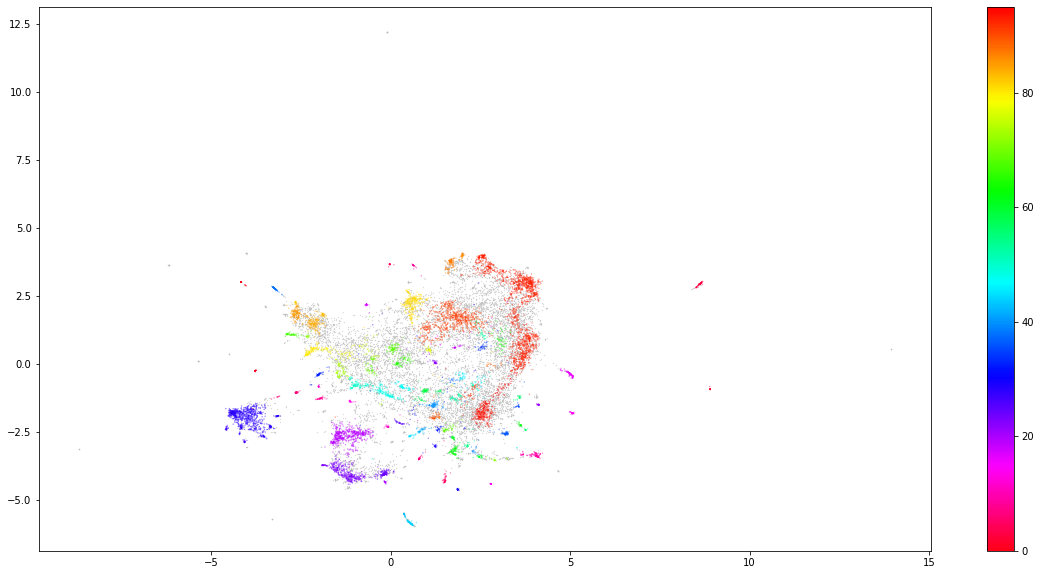

In [115]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

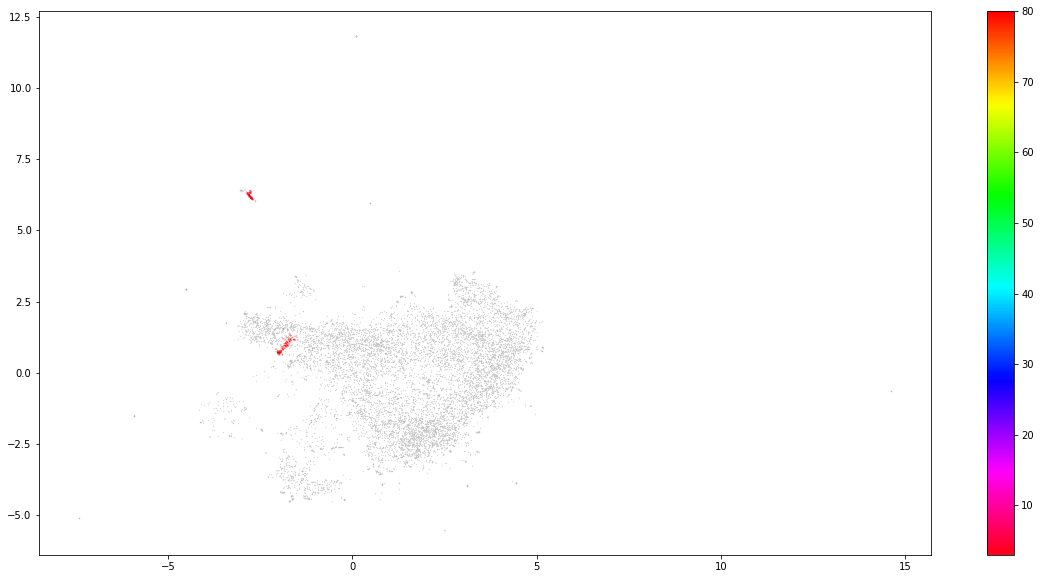

In [174]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels.isin( [80,3]), :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [116]:
cluster.labels_

array([-1, -1,  2, ..., -1, -1, 93])

In [117]:
docs_df = pd.DataFrame(newsgroups.data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [118]:
docs_df[:2]

,Doc,Topic,Doc_ID
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",-1,0
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,-1,1


Combining with earlier Dataframe

In [119]:
df_comb = pd.concat([data1, docs_df], axis=1, join="inner")

In [120]:
df_comb.keys()

Index(['Data', 'target', 'target_name', 'Doc', 'Topic', 'Doc_ID'], dtype='object')

In [121]:
df_comb[:2]

,Data,target,target_name,Doc,Topic,Doc_ID
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",10,rec.sport.hockey,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",-1,0
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3,comp.sys.ibm.pc.hardware,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,-1,1


Comparing the two types

In [123]:
#saving df_comb

In [124]:
mkPikle('pickle/20News/df_comb.pkl', df_comb)

Comparing the target name wise topic clustering

In [125]:
df_comb.groupby(['target_name','Topic']).agg({"Topic": ['count']})

Topic
                               count
target_name              Topic      
alt.atheism              -1      431
                          10       3
                          12      15
                          16      18
                          17       5
                          20       1
                          21       3
                          24       4
                          28       7
                          29      20
                          36       6
                          37       1
                          38      38
                          40       1
                          41       3
                          42       2
                          44       2
                          50       2
                          51       3
                          60      25
                          63       2
                          64       1
                          67       1
                          68       2
                          71      12
                          72       2
                          73       7
                          76       1
                          78       4
                          79      28
                          80      82
                          82       1
                          83       3
                          84      12
                          85      28
                          90       2
                          91       1
                          92       4
                          94      15
                          95       1
comp.graphics            -1      529
                          7        1
                          8        1
                          10      17
                          15       7
                          16      17
                          17       1
                          20       2
                          24       1
                          28      20
                          31       1
                          32       1
                          34       1
                          35       2
                          40       2
                          46       1
                          47       1
                          51       1
                          52       1
                          55       3
                          56       2
                          58       1
                          59       1
                          63       1
                          64       7
                          65       8
                          68       1
                          89       2
                          90       1
                          91     104
                          92      11
                          93     195
                          94      23
                          95       6
comp.os.ms-windows.misc  -1      541
                          1        2
                          4        6
                          7        2
                          10      10
                          15       3
                          16      10
                          17       3
                          20       1
                          21       1
                          22      35
                          24       9
                          28       2
                          31       4
                          32       1
                          35       2
                          36       1
                          40       3
                          41       2
                          50       1
                          51       2
                          52       1
                          53      21
                          55       6
                          59       3
                          64       6
                          68       2
                          77       1
                          81       2
                          89       1
                          90       1
                          91     15

In [126]:
topCount  = df_comb.groupby(['target_name','Topic']).agg({"Topic": ['count']})
# Change: groupby state_office and divide by sum
top_pcts = topCount.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [127]:
top_pcts.index.names

FrozenList(['target_name', 'Topic'])

In [128]:
top_pcts.keys()

MultiIndex([('Topic', 'count')],
           )

In [129]:
top_pcts.index.values

array([('alt.atheism', -1), ('alt.atheism', 10), ('alt.atheism', 12),
       ('alt.atheism', 16), ('alt.atheism', 17), ('alt.atheism', 20),
       ('alt.atheism', 21), ('alt.atheism', 24), ('alt.atheism', 28),
       ('alt.atheism', 29), ('alt.atheism', 36), ('alt.atheism', 37),
       ('alt.atheism', 38), ('alt.atheism', 40), ('alt.atheism', 41),
       ('alt.atheism', 42), ('alt.atheism', 44), ('alt.atheism', 50),
       ('alt.atheism', 51), ('alt.atheism', 60), ('alt.atheism', 63),
       ('alt.atheism', 64), ('alt.atheism', 67), ('alt.atheism', 68),
       ('alt.atheism', 71), ('alt.atheism', 72), ('alt.atheism', 73),
       ('alt.atheism', 76), ('alt.atheism', 78), ('alt.atheism', 79),
       ('alt.atheism', 80), ('alt.atheism', 82), ('alt.atheism', 83),
       ('alt.atheism', 84), ('alt.atheism', 85), ('alt.atheism', 90),
       ('alt.atheism', 91), ('alt.atheism', 92), ('alt.atheism', 94),
       ('alt.atheism', 95), ('comp.graphics', -1), ('comp.graphics', 7),
       ('comp.gra

In [130]:
top1 = top_pcts.reset_index()

In [131]:
top1.columns

MultiIndex([('target_name',      ''),
            (      'Topic',      ''),
            (      'Topic', 'count')],
           )

In [132]:
top1.index

RangeIndex(start=0, stop=707, step=1)

In [134]:
# for index, row in top1.loc[0:2].iterrows():
#     print(index, row[0], row[1], row[2])

In [135]:
# top1[top1.target_name=='comp.graphics'][top1['Topic', 'count']>1].sort_values(by=[
#             ('Topic', 'count')], ascending=False)

In [136]:
# top1[top1.target_name=='comp.graphics'][top1['Topic', 'count']>1].sort_values(by=[
#             ('Topic', 'count')], ascending=False)['Topic', ''].tolist()

In [137]:
# top1[top1.target_name=='comp.graphics'][top1['Topic', 'count']>1].sort_values(by=[
#             ('Topic', 'count')], ascending=False)['Topic', 'count'].tolist()

Create a Dataframe consisting of basic information about the data

In [138]:
import pandas as pd
def create_df_summary(per):
    df_summary_target = pd.DataFrame(columns = ['target_name', 'found_clusters', 'percent_clusters', 'total_count'])
    for target_name in df_overall.index.values.tolist():
        print(target_name)
        found_clusters = top1[top1.target_name==target_name][top1['Topic', 'count']>per].sort_values(by=[
                ('Topic', 'count')], ascending=False)['Topic', ''].tolist()
        percent_clusters = top1[top1.target_name==target_name][top1['Topic', 'count']>per].sort_values(by=[
                ('Topic', 'count')], ascending=False)['Topic', 'count'].tolist()
        total_count = df_overall.loc[(target_name), :][0]

        df_summary_target = df_summary_target.append({'target_name' : target_name, 'found_clusters' : found_clusters, 
                                        'percent_clusters' : percent_clusters, 'total_count' : total_count}, 
                                       ignore_index = True)
    return df_summary_target

In [139]:
df_summary_target = create_df_summary(2)

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


/tmp/ipykernel_22476/1982131253.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  found_clusters = top1[top1.target_name==target_name][top1['Topic', 'count']>per].sort_values(by=[
/tmp/ipykernel_22476/1982131253.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  percent_clusters = top1[top1.target_name==target_name][top1['Topic', 'count']>per].sort_values(by=[


In [24]:
df_summary_target

,target_name,found_clusters,percent_clusters,total_count
0,alt.atheism,"[-1, 80, 38, 79, 85, 60, 29, 16]","[53.942428035043804, 10.262828535669588, 4.755944931163955, 3.504380475594493, 3.504380475594493, 3.1289111389236544, 2.5031289111389237, 2.252816020025031]",799
1,comp.graphics,"[-1, 93, 91, 94, 28]","[54.367934224049336, 20.041109969167522, 10.688591983556012, 2.36382322713258, 2.055498458376156]",973
2,comp.os.ms-windows.misc,"[-1, 91, 93, 22, 53]","[54.923857868020306, 15.32994923857868, 12.081218274111675, 3.553299492385787, 2.1319796954314723]",985
3,comp.sys.ibm.pc.hardware,"[-1, 91, 93, 94]","[63.54378818737271, 10.488798370672098, 10.081466395112017, 2.443991853360489]",982
4,comp.sys.mac.hardware,"[-1, 93, 91, 34, 18, 9]","[61.163032191069576, 10.488058151609554, 10.176531671858775, 3.2191069574247146, 2.3883696780893042, 2.1806853582554515]",963
5,comp.windows.x,"[-1, 93, 91, 10, 28, 95]","[54.8582995951417, 14.777327935222672, 13.562753036437247, 4.352226720647773, 2.935222672064777, 2.0242914979757085]",988
6,misc.forsale,"[93, -1]","[46.56410256410256, 46.46153846153846]",975
7,rec.autos,"[-1, 93, 33, 0]","[54.64646464646464, 22.525252525252526, 4.444444444444445, 2.323232323232323]",990
8,rec.motorcycles,"[-1, 87, 94, 45, 86]","[65.36144578313252, 10.441767068273093, 3.714859437751004, 2.5100401606425704, 2.0080321285140563]",996
9,rec.sport.baseball,"[19, -1]","[49.69818913480885, 38.83299798792756]",994


In [25]:
# mkPikle('pickle/20News/df_summary_target.pkl', df_summary_target)

In the next phase we will try to find cluster wise targets

Only considering the clusters in earlier phase

In [143]:
#set(df_summary['found_clusters'].tolist())
setClusters = set()

for lst in df_summary_target['found_clusters'].tolist():
    print(lst)
    setClusters.update(lst)

[-1, 80, 38, 79, 85, 60, 29, 16]
[-1, 93, 91, 94, 28]
[-1, 91, 93, 22, 53]
[-1, 91, 93, 94]
[-1, 93, 91, 34, 18, 9]
[-1, 93, 91, 10, 28, 95]
[93, -1]
[-1, 93, 33, 0]
[-1, 87, 94, 45, 86]
[19, -1]
[-1, 23, 19, 24]
[-1, 46, 68, 66, 65, 94, 77]
[-1, 93, 28, 91]
[-1, 81, 52, 94]
[28, -1, 8, 27, 26]
[-1, 84, 85, 67, 80]
[-1, 48, 50, 47, 70, 49, 13]
[-1, 3, 62, 74, 73, 2, 61]
[-1, 44, 6, 5, 30, 43, 28, 50]
[-1, 38, 83, 85, 82, 84]


In [144]:
len(setClusters)

58

In [145]:
list(setClusters)[:2]

[0, 2]

In [146]:
df_comb_limited = df_comb[df_comb['Topic'].isin(list(setClusters))]

In [147]:
df_comb_limited[:2]

,Data,target,target_name,Doc,Topic,Doc_ID
0,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",10,rec.sport.hockey,"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game. PENS RULE!!!\n\n",-1,0
1,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,3,comp.sys.ibm.pc.hardware,My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM. Does anyone have suggestions/ideas on:\n\n - Diamond Stealth Pro Local Bus\n\n - Orchid Farenheit 1280\n\n - ATI Graphics Ultra Pro\n\n - Any other high-performance VLB card\n\n\nPlease post or email. Thank you!\n\n - Matt\n,-1,1


In [149]:
mkPikle('pickle/20News/df_comb_limited.pkl', df_comb_limited)

In [150]:
df_comb_limited.groupby(['Topic','target_name']).agg({"target_name": ['count']})

target_name
                                     count
Topic target_name                         
-1    alt.atheism                      431
      comp.graphics                    529
      comp.os.ms-windows.misc          541
      comp.sys.ibm.pc.hardware         624
      comp.sys.mac.hardware            589
      comp.windows.x                   542
      misc.forsale                     453
      rec.autos                        541
      rec.motorcycles                  651
      rec.sport.baseball               386
      rec.sport.hockey                 420
      sci.crypt                        640
      sci.electronics                  703
      sci.med                          536
      sci.space                        233
      soc.religion.christian           605
      talk.politics.guns               471
      talk.politics.mideast            530
      talk.politics.misc               406
      talk.religion.misc               389
 0    rec.autos                         23
      rec.motorcycles                    1
      soc.religion.christian             5
 2    talk.politics.mideast             25
 3    talk.politics.mideast            111
      talk.politics.misc                 1
 5    rec.autos                          1
      rec.sport.hockey                   1
      sci.crypt                          1
      talk.politics.guns                 2
      talk.politics.mideast              6
      talk.politics.misc                34
 6    rec.autos                          5
      rec.sport.baseball                 1
      talk.politics.mideast             11
      talk.politics.misc                36
 8    comp.graphics                      1
      rec.motorcycles                    2
      sci.electronics                    1
      sci.space                         35
 9    comp.sys.mac.hardware             21
      comp.windows.x                     1
 10   alt.atheism                        3
      comp.graphics                     17
      comp.os.ms-windows.misc           10
      comp.sys.ibm.pc.hardware           8
      comp.sys.mac.hardware              6
      comp.windows.x                    43
      rec.autos                          1
      rec.sport.hockey                   2
      sci.crypt                         18
      sci.electronics                    4
      sci.med                            2
      sci.space                          2
      soc.religion.christian             1
      talk.religion.misc                 1
 13   talk.politics.guns                19
      talk.politics.mideast              1
 16   alt.atheism                       18
      comp.graphics                     17
      comp.os.ms-windows.misc           10
      comp.sys.ibm.pc.hardware          10
      comp.sys.mac.hardware              8
      comp.windows.x                     6
      rec.autos                          2
      rec.sport.baseball                 1
      sci.crypt                          1
      sci.electronics                   11
      sci.med                            2
      sci.space                          3
      soc.religion.christian             4
      talk.politics.guns                 1
      talk.religion.misc                 1
 18   comp.sys.mac.hardware             23
      comp.windows.x                     1
      soc.religion.christian             1
 19   misc.forsale                       2
      rec.autos                          2
      rec.sport.baseball               494
      rec.sport.hockey                  60
      sci.med                            1
      sci.space                          1
      talk.politics.mideast              1
      talk.politics.misc                 6
 22   comp.os.ms-windows.misc           35
      comp.sys.ibm.pc.hardware           1
      rec.sport.hockey                   1
      sci.crypt                          1
 23   misc.forsale                       2
      rec.autos                          1
      rec.motorcycles           

In [14]:
tarCount  = df_comb_limited.groupby(['Topic','target_name']).agg({"target_name": ['count']})
# Change: groupby state_office and divide by sum
tar_pcts = tarCount.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [15]:
df_comb_limited.groupby(['Topic']).agg({"Topic": ['count']}).loc[-1,:][0]
#df_overall.loc[('alt.atheism'), :][0]

10220

In [16]:
tar_pcts

target_name
                                     count
Topic target_name                         
-1    alt.atheism                 4.217221
      comp.graphics               5.176125
      comp.os.ms-windows.misc     5.293542
      comp.sys.ibm.pc.hardware    6.105675
      comp.sys.mac.hardware       5.763209
      comp.windows.x              5.303327
      misc.forsale                4.432485
      rec.autos                   5.293542
      rec.motorcycles             6.369863
      rec.sport.baseball          3.776908
      rec.sport.hockey            4.109589
      sci.crypt                   6.262231
      sci.electronics             6.878669
      sci.med                     5.244618
      sci.space                   2.279843
      soc.religion.christian      5.919765
      talk.politics.guns          4.608611
      talk.politics.mideast       5.185910
      talk.politics.misc          3.972603
      talk.religion.misc          3.806262
 0    rec.autos                  79.310345
      rec.motorcycles             3.448276
      soc.religion.christian     17.241379
 2    talk.politics.mideast     100.000000
 3    talk.politics.mideast      99.107143
      talk.politics.misc          0.892857
 5    rec.autos                   2.222222
      rec.sport.hockey            2.222222
      sci.crypt                   2.222222
      talk.politics.guns          4.444444
      talk.politics.mideast      13.333333
      talk.politics.misc         75.555556
 6    rec.autos                   9.433962
      rec.sport.baseball          1.886792
      talk.politics.mideast      20.754717
      talk.politics.misc         67.924528
 8    comp.graphics               2.564103
      rec.motorcycles             5.128205
      sci.electronics             2.564103
      sci.space                  89.743590
 9    comp.sys.mac.hardware      95.454545
      comp.windows.x              4.545455
 10   alt.atheism                 2.542373
      comp.graphics              14.406780
      comp.os.ms-windows.misc     8.474576
      comp.sys.ibm.pc.hardware    6.779661
      comp.sys.mac.hardware       5.084746
      comp.windows.x             36.440678
      rec.autos                   0.847458
      rec.sport.hockey            1.694915
      sci.crypt                  15.254237
      sci.electronics             3.389831
      sci.med                     1.694915
      sci.space                   1.694915
      soc.religion.christian      0.847458
      talk.religion.misc          0.847458
 13   talk.politics.guns         95.000000
      talk.politics.mideast       5.000000
 16   alt.atheism                18.947368
      comp.graphics              17.894737
      comp.os.ms-windows.misc    10.526316
      comp.sys.ibm.pc.hardware   10.526316
      comp.sys.mac.hardware       8.421053
      comp.windows.x              6.315789
      rec.autos                   2.105263
      rec.sport.baseball          1.052632
      sci.crypt                   1.052632
      sci.electronics            11.578947
      sci.med                     2.105263
      sci.space                   3.157895
      soc.religion.christian      4.210526
      talk.politics.guns          1.052632
      talk.religion.misc          1.052632
 18   comp.sys.mac.hardware      92.000000
      comp.windows.x              4.000000
      soc.religion.christian      4.000000
 19   misc.forsale                0.352734
      rec.autos                   0.352734
      rec.sport.baseball         87.125220
      rec.sport.hockey           10.582011
      sci.med                     0.176367
      sci.space                   0.176367
      talk.politics.mideast       0.176367
      talk.politics.misc          1.058201
 22   comp.os.ms-windows.misc    92.105263
      comp.sys.ibm.pc.hardware    2.631579
      rec.sport.hockey            2.631579
      sci.crypt                   2.631579
 23   misc.forsale                0.471698
      rec.autos                   0.235849
      rec.motorcycles           

In [17]:
top_s= tar_pcts.reset_index()

In [18]:
top_s.keys()

MultiIndex([(      'Topic',      ''),
            ('target_name',      ''),
            ('target_name', 'count')],
           )

In [19]:
len(set(top_s.Topic.tolist()))

58

In [158]:
top_s[:5]

Topic               target_name          
                                      count
0    -1               alt.atheism  4.217221
1    -1             comp.graphics  5.176125
2    -1   comp.os.ms-windows.misc  5.293542
3    -1  comp.sys.ibm.pc.hardware  6.105675
4    -1     comp.sys.mac.hardware  5.763209

In [159]:
 top_s[top_s.Topic==-1].sort_values(by=[
            ('target_name', 'count')], ascending=False)['target_name', ''].tolist()

['sci.electronics',
 'rec.motorcycles',
 'sci.crypt',
 'comp.sys.ibm.pc.hardware',
 'soc.religion.christian',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'comp.os.ms-windows.misc',
 'rec.autos',
 'sci.med',
 'talk.politics.mideast',
 'comp.graphics',
 'talk.politics.guns',
 'misc.forsale',
 'alt.atheism',
 'rec.sport.hockey',
 'talk.politics.misc',
 'talk.religion.misc',
 'rec.sport.baseball',
 'sci.space']

In [21]:
#create dataframe by clusters

# df_summary_topic = pd.DataFrame(columns = ['topic', 'found_targets', 'percent_targets', 'total_count'])
# for Topic in list(setClusters):
#     print(Topic)
#     found_targets =  top_s[top_s.Topic==Topic].sort_values(by=[
#             ('target_name', 'count')], ascending=False)['target_name', ''].tolist()
#     percent_targets =  top_s[top_s.Topic==Topic].sort_values(by=[
#             ('target_name', 'count')], ascending=False)['target_name', 'count'].tolist()
#     total_count = df_comb_limited.groupby(['Topic']).agg({"Topic": ['count']}).loc[Topic,:][0]
    
#     df_summary_topic = df_summary_topic.append({'topic' : Topic, 'found_targets' : found_targets, 
#                                     'percent_targets' : percent_targets, 'total_count' : total_count}, 
#                                    ignore_index = True)

In [12]:

df_summary_topic

,topic,found_targets,percent_targets,total_count
0,0,"[rec.autos, soc.religion.christian, rec.motorcycles]","[79.3103448275862, 17.24137931034483, 3.4482758620689653]",29
1,2,[talk.politics.mideast],[100.0],25
2,3,"[talk.politics.mideast, talk.politics.misc]","[99.10714285714286, 0.8928571428571429]",112
3,5,"[talk.politics.misc, talk.politics.mideast, talk.politics.guns, rec.autos, rec.sport.hockey, sci.crypt]","[75.55555555555556, 13.333333333333334, 4.444444444444445, 2.2222222222222223, 2.2222222222222223, 2.2222222222222223]",45
4,6,"[talk.politics.misc, talk.politics.mideast, rec.autos, rec.sport.baseball]","[67.9245283018868, 20.754716981132077, 9.433962264150944, 1.8867924528301887]",53
5,8,"[sci.space, rec.motorcycles, comp.graphics, sci.electronics]","[89.74358974358974, 5.128205128205129, 2.5641025641025643, 2.5641025641025643]",39
6,9,"[comp.sys.mac.hardware, comp.windows.x]","[95.45454545454545, 4.545454545454546]",22
7,10,"[comp.windows.x, sci.crypt, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, sci.electronics, alt.atheism, rec.sport.hockey, sci.med, sci.space, rec.autos, soc.religion.christian, talk.religion.misc]","[36.440677966101696, 15.254237288135593, 14.40677966101695, 8.474576271186441, 6.779661016949152, 5.084745762711864, 3.389830508474576, 2.542372881355932, 1.694915254237288, 1.694915254237288, 1.694915254237288, 0.847457627118644, 0.847457627118644, 0.847457627118644]",118
8,13,"[talk.politics.guns, talk.politics.mideast]","[95.0, 5.0]",20
9,16,"[alt.atheism, comp.graphics, sci.electronics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, soc.religion.christian, sci.space, rec.autos, sci.med, rec.sport.baseball, sci.crypt, talk.politics.guns, talk.religion.misc]","[18.94736842105263, 17.894736842105264, 11.578947368421053, 10.526315789473685, 10.526315789473685, 8.421052631578947, 6.315789473684211, 4.2105263157894735, 3.1578947368421053, 2.1052631578947367, 2.1052631578947367, 1.0526315789473684, 1.0526315789473684, 1.0526315789473684, 1.0526315789473684]",95


In [28]:
#top_pcts.loc[('alt.atheism', ),]

#mkPikle('pickle/20News/df_summary_topic.pkl',df_summary_topic)


Summary again

In [11]:
df_summary_target

,target_name,found_clusters,percent_clusters,total_count
0,alt.atheism,"[-1, 80, 38, 79, 85, 60, 29, 16]","[53.942428035043804, 10.262828535669588, 4.755944931163955, 3.504380475594493, 3.504380475594493, 3.1289111389236544, 2.5031289111389237, 2.252816020025031]",799
1,comp.graphics,"[-1, 93, 91, 94, 28]","[54.367934224049336, 20.041109969167522, 10.688591983556012, 2.36382322713258, 2.055498458376156]",973
2,comp.os.ms-windows.misc,"[-1, 91, 93, 22, 53]","[54.923857868020306, 15.32994923857868, 12.081218274111675, 3.553299492385787, 2.1319796954314723]",985
3,comp.sys.ibm.pc.hardware,"[-1, 91, 93, 94]","[63.54378818737271, 10.488798370672098, 10.081466395112017, 2.443991853360489]",982
4,comp.sys.mac.hardware,"[-1, 93, 91, 34, 18, 9]","[61.163032191069576, 10.488058151609554, 10.176531671858775, 3.2191069574247146, 2.3883696780893042, 2.1806853582554515]",963
5,comp.windows.x,"[-1, 93, 91, 10, 28, 95]","[54.8582995951417, 14.777327935222672, 13.562753036437247, 4.352226720647773, 2.935222672064777, 2.0242914979757085]",988
6,misc.forsale,"[93, -1]","[46.56410256410256, 46.46153846153846]",975
7,rec.autos,"[-1, 93, 33, 0]","[54.64646464646464, 22.525252525252526, 4.444444444444445, 2.323232323232323]",990
8,rec.motorcycles,"[-1, 87, 94, 45, 86]","[65.36144578313252, 10.441767068273093, 3.714859437751004, 2.5100401606425704, 2.0080321285140563]",996
9,rec.sport.baseball,"[19, -1]","[49.69818913480885, 38.83299798792756]",994


Considering the Group - alt.atheism



In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

**alt.atheism**

Clusters : [-1, 80, 38, 79, 85, 60, 29, 16]	
Percentage : [53.942428035043804, 10.262828535669588, 4.755944931163955, 3.504380475594493, 3.504380475594493, 3.1289111389236544, 2.5031289111389237, 2.252816020025031]	
Total : 799

<i>Clusters</i>

80	
categories : [alt.atheism, soc.religion.christian, sci.med, talk.politics.misc]	
Percentage : [66.12903225806451, 32.25806451612903, 0.8064516129032258, 0.8064516129032258]	
Total : 124


38	
categories : [talk.religion.misc, alt.atheism, soc.religion.christian]	
Percentage : [55.319148936170215, 40.42553191489362, 4.25531914893617]	
Total : 94

79	
categories : [alt.atheism]	
percentage : [100.0]	
Total : 28

85	
categories : [soc.religion.christian, alt.atheism, talk.religion.misc, rec.sport.baseball]	
percentage : [64.42953020134229, 18.79194630872483, 16.107382550335572, 0.6711409395973155]	
Total : 149

60	
categories : [alt.atheism]	
percentage : [100.0]	
Total : 25

29	
categories : [alt.atheism, rec.sport.baseball]	
percentage : [95.23809523809524, 4.761904761904762]	
Total : 21

16	
categories : [alt.atheism, comp.graphics, sci.electronics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, soc.religion.christian, sci.space, rec.autos, sci.med, rec.sport.baseball, sci.crypt, talk.politics.guns, talk.religion.misc]	
percentage : [18.94736842105263, 17.894736842105264, 11.578947368421053, 10.526315789473685, 10.526315789473685, 8.421052631578947, 6.315789473684211, 4.2105263157894735, 3.1578947368421053, 2.1052631578947367, 2.1052631578947367, 1.0526315789473684, 1.0526315789473684, 1.0526315789473684, 1.0526315789473684]	
Total : 95

Checking 85 Cluster foor baseball cases

In [30]:
df_comb_limited[(df_comb_limited['target_name']=='rec.sport.baseball' ) & (df_comb_limited['Topic']==85)]

,Data,target,target_name,Doc,Topic,Doc_ID
15512,"As I recall from Kieth Hernandez' 'auto'biography, Rusty is a devout\nRoman Catholic. Kieth and Rusty would carpool to Shea everyday but\nSunday, when Rusty would go to mass.\nSC\n",9,rec.sport.baseball,"As I recall from Kieth Hernandez' 'auto'biography, Rusty is a devout\nRoman Catholic. Kieth and Rusty would carpool to Shea everyday but\nSunday, when Rusty would go to mass.\nSC\n",85,15512


Checking 29 Cluster for baseball cases

In [31]:
df_comb_limited[(df_comb_limited['target_name']=='rec.sport.baseball' ) & (df_comb_limited['Topic']==29)]

,Data,target,target_name,Doc,Topic,Doc_ID
554,"\n\nI was in fact going to suggest that Roger take his way of discussion over\nto r.s.football.pro. There this kind of hormone-only reasoning is the\nstandard. Being he canadian, and hockey what it is, I would have suggested\nthat r.s.h would work too. It is important in a thread that everyone\ninvolved use the same body part to produce a post (brain being the organ\nof choice here).",9,rec.sport.baseball,"\n\nI was in fact going to suggest that Roger take his way of discussion over\nto r.s.football.pro. There this kind of hormone-only reasoning is the\nstandard. Being he canadian, and hockey what it is, I would have suggested\nthat r.s.h would work too. It is important in a thread that everyone\ninvolved use the same body part to produce a post (brain being the organ\nof choice here).",29,554


Checking 16 Cluster for Computer graphics cases

In [32]:
df_comb_limited[(df_comb_limited['target_name']=='comp.graphics' ) & (df_comb_limited['Topic']==16)]

Data  \
596                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

**Based on the analysis We can determine how many of Clusters are correct**

A cluster can consists of many classes. If the majority of a cluster belong to one type, then the cluster belong to that category.

Based on that data, we will determine the accuracy of identified clusters

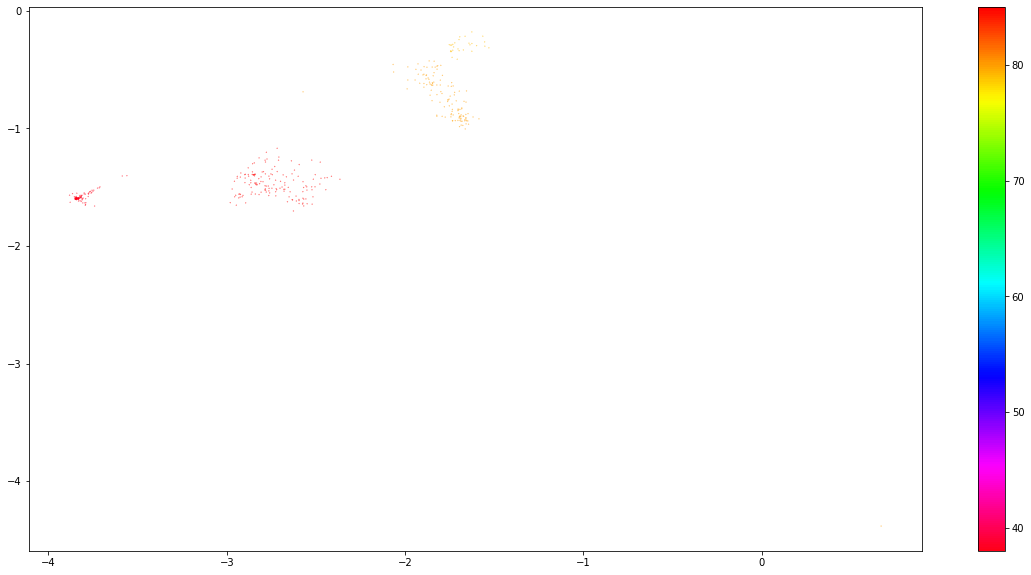

In [6]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels.isin([80,38,79,85]), :]
#plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [33]:
#docs_per_topic